In [1]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from contextlib import contextmanager
import joblib
from tqdm import tqdm
import os
import pathlib
tqdm.pandas()

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Ellipse, Circle
import seaborn as sns

from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon

pd.set_option('display.max_rows', 500)

from IPython.display import HTML

In [2]:
# Set random seed for reproducibility
np.random.seed(123)

# Constants
N = 100
N_sim = int(1e7)
base_null = 0.5

# Simulate binomial trials
red = np.random.binomial(N, base_null, size=N_sim)
blue = N - red

# leader calculation: pick the larger count from red or blue
leader = np.maximum(red, blue)
leader_pct = leader / N

In [3]:
def mcttest(l, f):

    l1_mean = np.mean(l)
    f1_mean = np.mean(f)
    t1_mean = 1 - (l1_mean + f1_mean)

    leader_bar = l1_mean / (l1_mean + f1_mean)

    pvalue = np.mean(leader_pct > leader_bar)

    # return an object that can be .pvalue -ed
    return pd.Series({
        'pvalue': pvalue,
    })

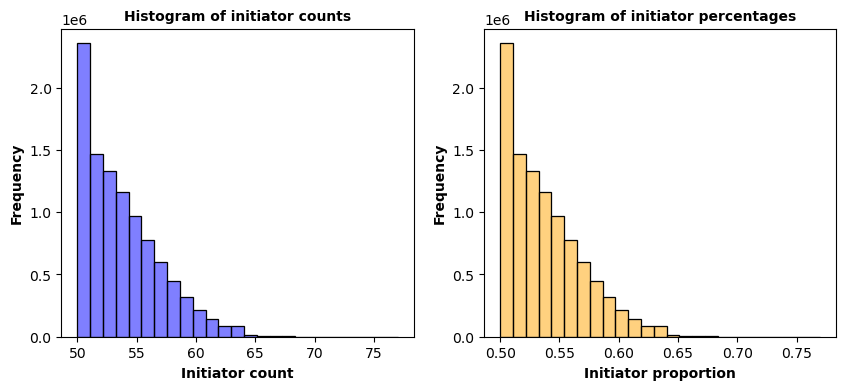

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Histograms
sns.histplot(leader, bins=25, kde=False, color='blue', alpha=0.5, ax = axs[0])
axs[0].set_title("Histogram of initiator counts", fontsize=10, fontweight='bold')
axs[0].set_xlabel("Initiator count", fontsize=10, fontweight='bold')
axs[0].set_ylabel("Frequency", fontsize=10, fontweight='bold')

sns.histplot(leader_pct, bins=25, kde=False, color='orange', alpha=0.5, ax = axs[1])
axs[1].set_title("Histogram of initiator percentages", fontsize=10, fontweight='bold')
axs[1].set_xlabel("Initiator proportion", fontsize=10, fontweight='bold')
axs[1].set_ylabel("Frequency", fontsize=10, fontweight='bold')
plt.show()

In [5]:
base= "../store_bk"
trains = sorted(os.listdir(base))

strat_1 = []
strat_2 = []
strat_3 = []

train_tt = []

for i in tqdm(trains[:]):
    f = f"{base}/{i}/trial_stats/training_1.parquet"
    t = pd.read_parquet(f)
    train_tt.append(t.trial_id.max())
    strat_1.append(t.activated_by.value_counts().to_dict())
    strat_2.append(t.first_close_to_zone.value_counts().to_dict())
    strat_3.append(t.first_to_zone.value_counts().to_dict())

100%|██████████| 100/100 [00:04<00:00, 22.60it/s]


In [6]:
l1 = [ "a1" if e["a1"] > e["a2"] else "a2" for e in strat_1]
f1 = [ "a1" if e["a1"] < e["a2"] else "a2" for e in strat_1]

l2 = [ "a1" if e["a1"] > e["a2"] else "a2" for e in strat_2]
f2 = [ "a1" if e["a1"] < e["a2"] else "a2" for e in strat_2]

l3 = [ "a1" if e["a1"] > e["a2"] else "a2" for e in strat_3]
f3 = [ "a1" if e["a1"] < e["a2"] else "a2" for e in strat_3]

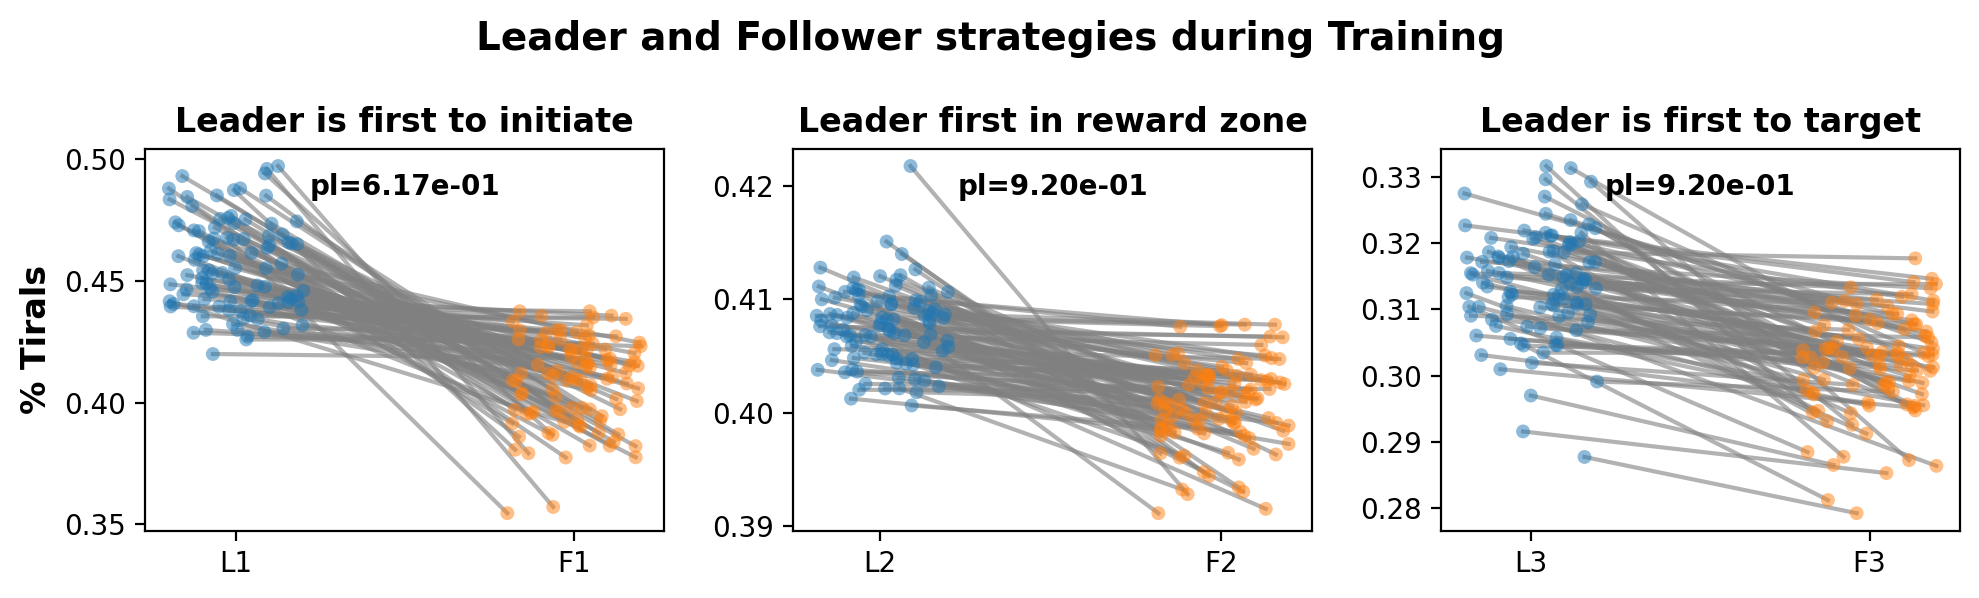

In [7]:
# Plotting the leaders and followers aligned
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False, dpi=200)

# getting the leader 1
# l1_data = {
#     'L1': [strat_1[i][l] for i, l in enumerate(l1)],
#     'F1': [strat_1[i][l] for i, l in enumerate(f1)],
# }

# l2_data = {
#     'L2': [strat_2[i][l] for i, l in enumerate(l2)],
#     'F2': [strat_2[i][l] for i, l in enumerate(f2)],
# }

# l3_data = {
#     'L3': [strat_3[i][l] for i, l in enumerate(l3)],
#     'F3': [strat_3[i][l] for i, l in enumerate(f3)],
# }
 
l1_data = {
    'L1': [strat_1[i][l]/train_tt[i] for i, l in enumerate(l1)],
    'F1': [strat_1[i][l]/train_tt[i] for i, l in enumerate(f1)],
}

l2_data = {
    'L2': [strat_2[i][l]/train_tt[i] for i, l in enumerate(l2)],
    'F2': [strat_2[i][l]/train_tt[i] for i, l in enumerate(f2)],
}

l3_data = {
    'L3': [strat_3[i][l]/train_tt[i] for i, l in enumerate(l3)],
    'F3': [strat_3[i][l]/train_tt[i] for i, l in enumerate(f3)],
}

ax = sns.stripplot(data=l1_data, ax=axs[0], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L1", "F1"]):
    offsets[category] = np.array(collection.get_offsets())

# Draw connecting lines
for i in range(len(l1)):
    x1, y1 = offsets["L1"][i]
    x2, y2 = offsets["F1"][i]
    axs[0].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)

pt = mcttest(l1_data['L1'], l1_data['F1']).pvalue
pmw = mannwhitneyu(l1_data['L1'], l1_data['F1']).pvalue
axs[0].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=10, fontweight='bold')
axs[0].set_title('Leader is first to initiate', fontsize=12, fontweight='bold')

ax = sns.stripplot(data=l2_data, ax=axs[1], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L2", "F2"]):
    offsets[category] = np.array(collection.get_offsets())

# Draw connecting lines
for i in range(len(l2)):
    x1, y1 = offsets["L2"][i]
    x2, y2 = offsets["F2"][i]
    axs[1].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)

pt = mcttest(l2_data['L2'], l2_data['F2']).pvalue
pmw = mannwhitneyu(l2_data['L2'], l2_data['F2']).pvalue
axs[1].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=10, fontweight='bold')
axs[1].set_title('Leader first in reward zone', fontsize=12, fontweight='bold')

ax = sns.stripplot(data=l3_data, ax=axs[2], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L3", "F3"]):
    offsets[category] = np.array(collection.get_offsets())

# Draw connecting lines
for i in range(len(l3)):
    x1, y1 = offsets["L3"][i]
    x2, y2 = offsets["F3"][i]
    axs[2].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)

pt = mcttest(l3_data['L3'], l3_data['F3']).pvalue
pmw = mannwhitneyu(l3_data['L3'], l3_data['F3']).pvalue
axs[2].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[2].transAxes, fontsize=10, fontweight='bold')
axs[2].set_title('Leader is first to target', fontsize=12, fontweight='bold')
axs[0].set_ylabel('% Tirals', fontsize=12, fontweight='bold')

plt.suptitle('Leader and Follower strategies during Training', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:

base= "../store_bk"
trains = sorted(os.listdir(base))

strat_1 = []
strat_2 = []
strat_3 = []

eval_tt = []

for i in tqdm(trains[:]):
    f = f"{base}/{i}/trial_stats/testing_1.parquet"
    t = pd.read_parquet(f)
    eval_tt.append(t.trial_id.max())
    strat_1.append(t.activated_by.value_counts().to_dict())
    strat_2.append(t.first_close_to_zone.value_counts().to_dict())
    strat_3.append(t.first_to_zone.value_counts().to_dict())

100%|██████████| 100/100 [00:01<00:00, 51.29it/s]


In [9]:
# es1_l1 = [ strat_1[i][leader] for i, leader in enumerate(l1)]
# es1_f1 = [ strat_1[i][follower] for i, follower in enumerate(f1)]

# es1_l2 = [ strat_2[i][leader] for i, leader in enumerate(l1)]
# es1_f2 = [ strat_2[i][follower] for i, follower in enumerate(f1)]

# es1_l3 = [ strat_3[i][leader] for i, leader in enumerate(l1)]
# es1_f3 = [ strat_3[i][follower] for i, follower in enumerate(f1)]

es1_l1 = [ strat_1[i][leader] / eval_tt[i] for i, leader in enumerate(l1)]
es1_f1 = [ strat_1[i][follower] / eval_tt[i] for i, follower in enumerate(f1)]

es1_l2 = [ strat_2[i][leader] / eval_tt[i] for i, leader in enumerate(l1)]
es1_f2 = [ strat_2[i][follower] / eval_tt[i] for i, follower in enumerate(f1)]

es1_l3 = [ strat_3[i][leader] / eval_tt[i] for i, leader in enumerate(l1)]
es1_f3 = [ strat_3[i][follower] / eval_tt[i] for i, follower in enumerate(f1)]

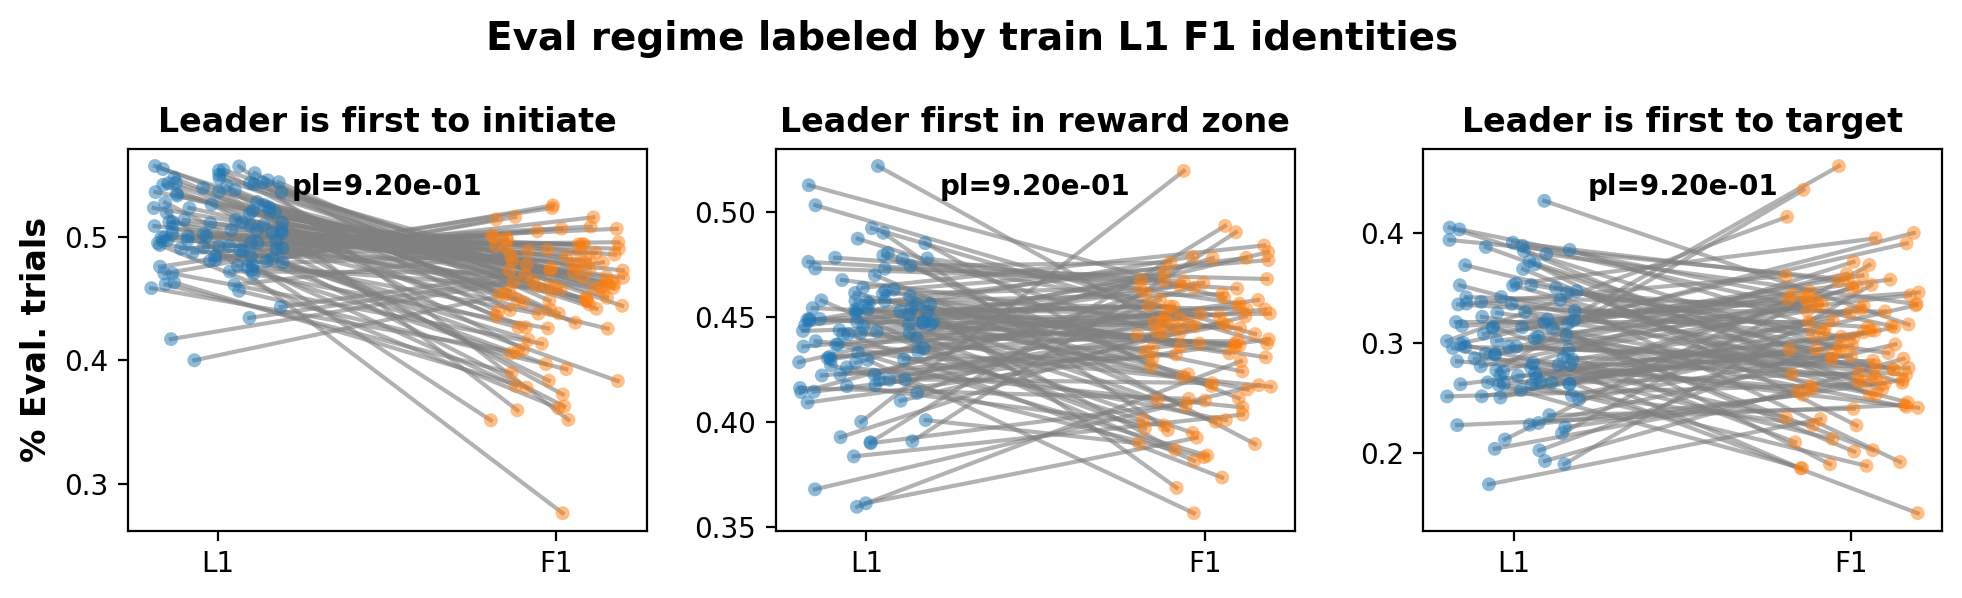

In [10]:
# Plotting the leaders and followers aligned
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False, dpi=200)

# getting the leader 1
l1_data = {
    'L1': es1_l1,
    'F1': es1_f1,
}

l2_data = {
    'L1': es1_l2,
    'F1': es1_f2,
}

l3_data = {
    'L1': es1_l3,
    'F1': es1_f3,
}

#########################################
ax = sns.stripplot(data=l1_data, ax=axs[0], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L1", "F1"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l1)):
    x1, y1 = offsets["L1"][i]
    x2, y2 = offsets["F1"][i]
    axs[0].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l1_data['L1'], l1_data['F1']).pvalue
pmw = mannwhitneyu(l1_data['L1'], l1_data['F1']).pvalue
axs[0].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=10, fontweight='bold')
axs[0].set_title('Leader is first to initiate', fontsize=12, fontweight='bold')

#########################################
ax = sns.stripplot(data=l2_data, ax=axs[1], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L1", "F1"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l2)):
    x1, y1 = offsets["L1"][i]
    x2, y2 = offsets["F1"][i]
    axs[1].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l2_data['L1'], l2_data['F1']).pvalue
pmw = mannwhitneyu(l2_data['L1'], l2_data['F1']).pvalue
axs[1].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=10, fontweight='bold')
axs[1].set_title('Leader first in reward zone', fontsize=12, fontweight='bold')

#########################################
ax = sns.stripplot(data=l3_data, ax=axs[2], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L1", "F1"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l3)):
    x1, y1 = offsets["L1"][i]
    x2, y2 = offsets["F1"][i]
    axs[2].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l3_data['L1'], l3_data['F1']).pvalue
pmw = mannwhitneyu(l3_data['L1'], l3_data['F1']).pvalue
axs[2].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[2].transAxes, fontsize=10, fontweight='bold')
axs[2].set_title('Leader is first to target', fontsize=12, fontweight='bold')
axs[0].set_ylabel('% Eval. trials', fontsize=12, fontweight='bold')

#########################################
plt.suptitle("Eval regime labeled by train L1 F1 identities", fontsize=14, fontweight='bold')
plt.tight_layout()

plt.show()

In [11]:
# es1_l1 = [ strat_1[i][leader] for i, leader in enumerate(l2)]
# es1_f1 = [ strat_1[i][follower] for i, follower in enumerate(f2)]

# es1_l2 = [ strat_2[i][leader] for i, leader in enumerate(l2)]
# es1_f2 = [ strat_2[i][follower] for i, follower in enumerate(f2)]

# es1_l3 = [ strat_3[i][leader] for i, leader in enumerate(l2)]
# es1_f3 = [ strat_3[i][follower] for i, follower in enumerate(f2)]

es1_l1 = [ strat_1[i][leader] / eval_tt[i] for i, leader in enumerate(l2)]
es1_f1 = [ strat_1[i][follower] / eval_tt[i] for i, follower in enumerate(f2)]

es1_l2 = [ strat_2[i][leader] / eval_tt[i] for i, leader in enumerate(l2)]
es1_f2 = [ strat_2[i][follower] / eval_tt[i] for i, follower in enumerate(f2)]

es1_l3 = [ strat_3[i][leader] / eval_tt[i] for i, leader in enumerate(l2)]
es1_f3 = [ strat_3[i][follower] / eval_tt[i] for i, follower in enumerate(f2)]

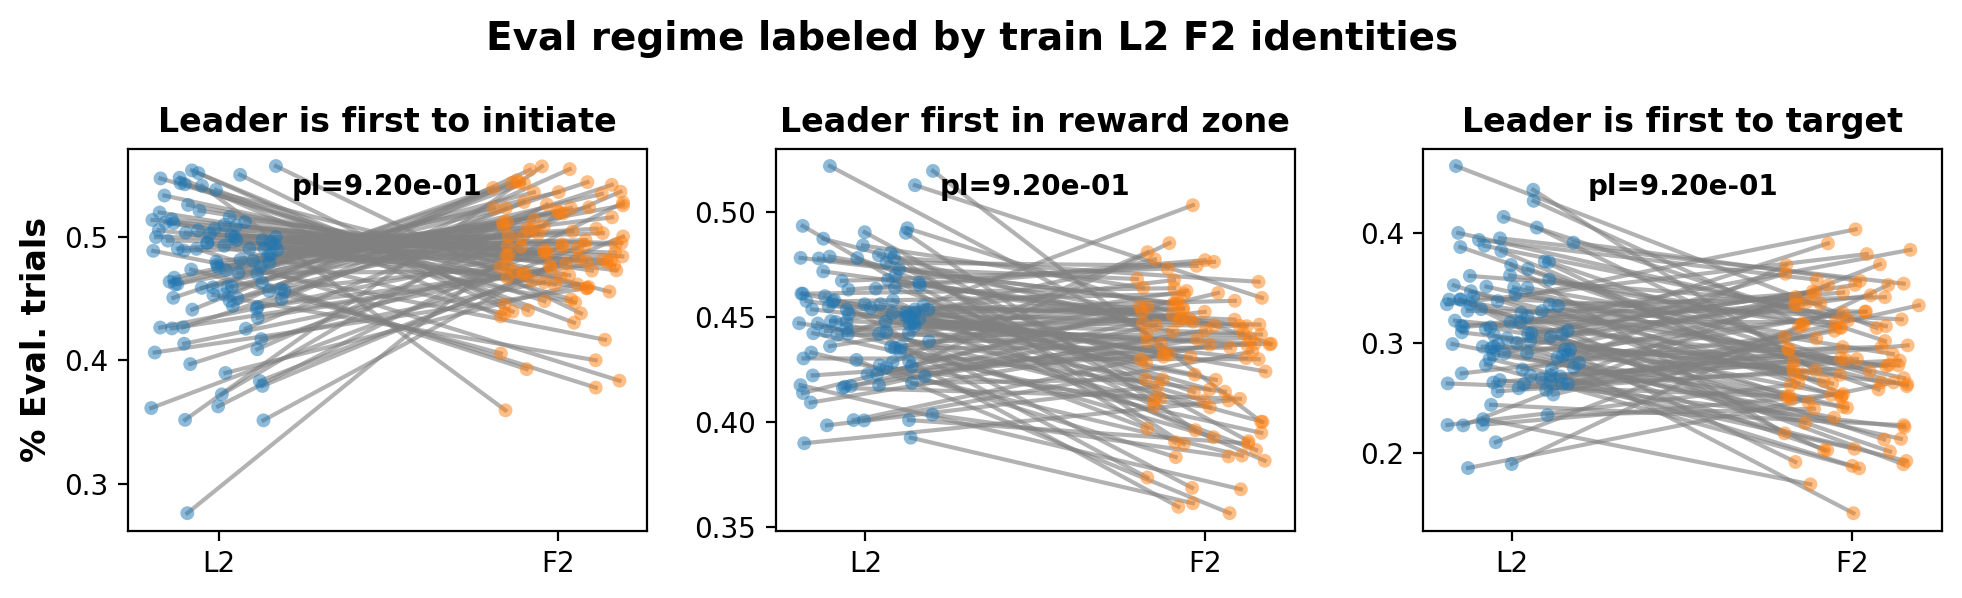

In [12]:
# Plotting the leaders and followers aligned
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False, dpi=200)

# getting the leader 1
l1_data = {
    'L2': es1_l1,
    'F2': es1_f1,
}

l2_data = {
    'L2': es1_l2,
    'F2': es1_f2,
}

l3_data = {
    'L2': es1_l3,
    'F2': es1_f3,
}

#########################################
ax = sns.stripplot(data=l1_data, ax=axs[0], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L2", "F2"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l1)):
    x1, y1 = offsets["L2"][i]
    x2, y2 = offsets["F2"][i]
    axs[0].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l1_data['L2'], l1_data['F2']).pvalue
pmw = mannwhitneyu(l1_data['L2'], l1_data['F2']).pvalue
axs[0].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=10, fontweight='bold')
axs[0].set_title('Leader is first to initiate', fontsize=12, fontweight='bold')

#########################################
ax = sns.stripplot(data=l2_data, ax=axs[1], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L2", "F2"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l2)):
    x1, y1 = offsets["L2"][i]
    x2, y2 = offsets["F2"][i]
    axs[1].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l2_data['L2'], l2_data['F2']).pvalue
pmw = mannwhitneyu(l2_data['L2'], l2_data['F2']).pvalue
axs[1].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=10, fontweight='bold')
axs[1].set_title('Leader first in reward zone', fontsize=12, fontweight='bold')

#########################################
ax = sns.stripplot(data=l3_data, ax=axs[2], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L2", "F2"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l3)):
    x1, y1 = offsets["L2"][i]
    x2, y2 = offsets["F2"][i]
    axs[2].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l3_data['L2'], l3_data['F2']).pvalue
pmw = mannwhitneyu(l3_data['L2'], l3_data['F2']).pvalue
axs[2].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[2].transAxes, fontsize=10, fontweight='bold')
axs[2].set_title('Leader is first to target', fontsize=12, fontweight='bold')
axs[0].set_ylabel('% Eval. trials', fontsize=12, fontweight='bold')

#########################################
plt.suptitle("Eval regime labeled by train L2 F2 identities", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
# es1_l1 = [ strat_1[i][leader] for i, leader in enumerate(l3)]
# es1_f1 = [ strat_1[i][follower] for i, follower in enumerate(f3)]

# es1_l2 = [ strat_2[i][leader] for i, leader in enumerate(l3)]
# es1_f2 = [ strat_2[i][follower] for i, follower in enumerate(f3)]

# es1_l3 = [ strat_3[i][leader] for i, leader in enumerate(l3)]
# es1_f3 = [ strat_3[i][follower] for i, follower in enumerate(f3)]

es1_l1 = [ strat_1[i][leader] / eval_tt[i] for i, leader in enumerate(l3)]
es1_f1 = [ strat_1[i][follower] / eval_tt[i] for i, follower in enumerate(f3)]

es1_l2 = [ strat_2[i][leader] / eval_tt[i] for i, leader in enumerate(l3)]
es1_f2 = [ strat_2[i][follower] / eval_tt[i] for i, follower in enumerate(f3)]

es1_l3 = [ strat_3[i][leader] / eval_tt[i] for i, leader in enumerate(l3)]
es1_f3 = [ strat_3[i][follower] / eval_tt[i] for i, follower in enumerate(f3)]

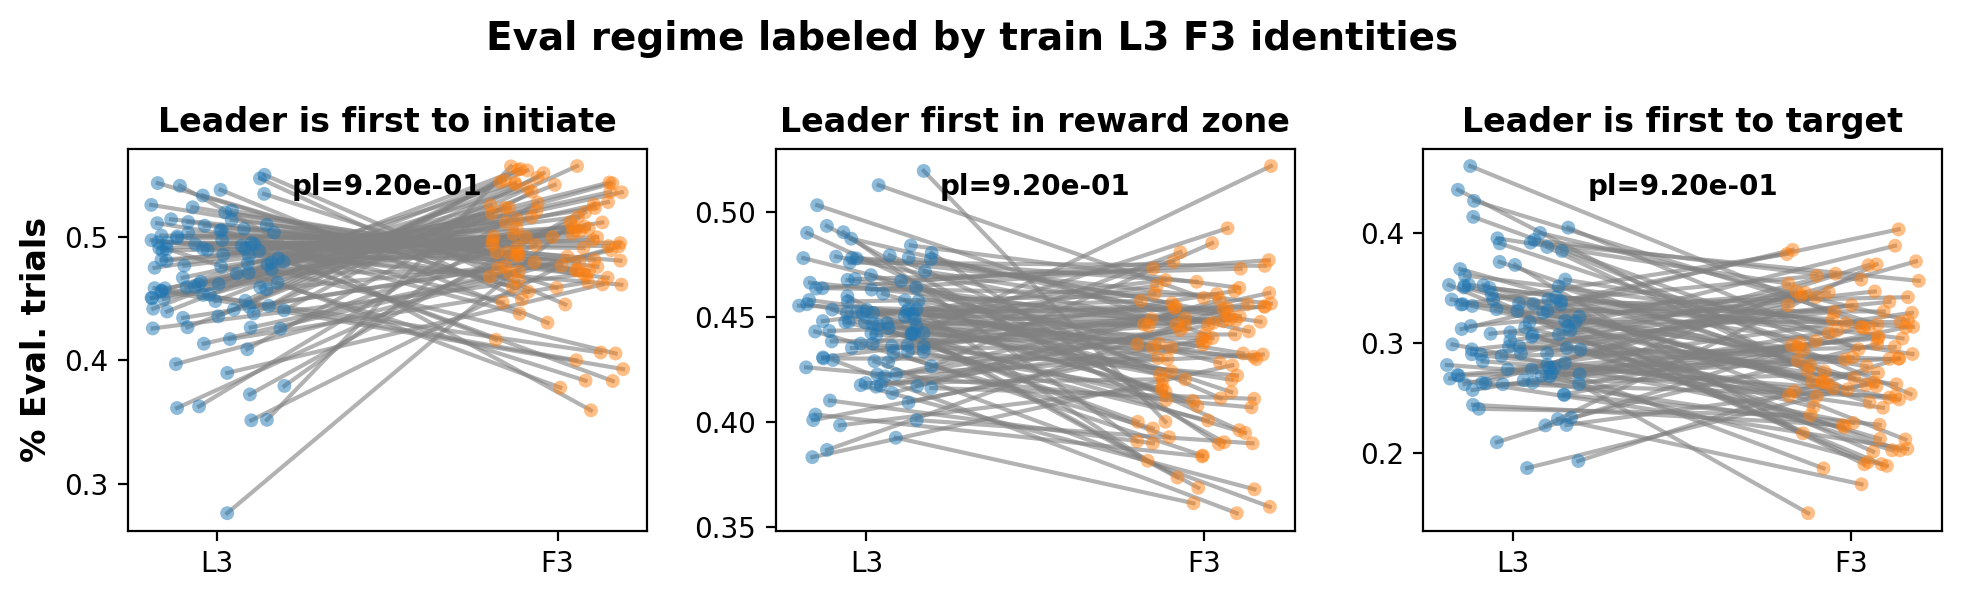

In [14]:
# Plotting the leaders and followers aligned
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False, dpi=200)

# getting the leader 1
l1_data = {
    'L3': es1_l1,
    'F3': es1_f1,
}

l2_data = {
    'L3': es1_l2,
    'F3': es1_f2,
}

l3_data = {
    'L3': es1_l3,
    'F3': es1_f3,
}

#########################################
ax = sns.stripplot(data=l1_data, ax=axs[0], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L3", "F3"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l1)):
    x1, y1 = offsets["L3"][i]
    x2, y2 = offsets["F3"][i]
    axs[0].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l1_data['L3'], l1_data['F3']).pvalue
pmw = mannwhitneyu(l1_data['L3'], l1_data['F3']).pvalue
axs[0].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=10, fontweight='bold')
axs[0].set_title('Leader is first to initiate', fontsize=12, fontweight='bold')

#########################################
ax = sns.stripplot(data=l2_data, ax=axs[1], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L3", "F3"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l2)):
    x1, y1 = offsets["L3"][i]
    x2, y2 = offsets["F3"][i]
    axs[1].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l2_data['L3'], l2_data['F3']).pvalue
pmw = mannwhitneyu(l2_data['L3'], l2_data['F3']).pvalue
axs[1].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=10, fontweight='bold')
axs[1].set_title('Leader first in reward zone', fontsize=12, fontweight='bold')

#########################################
ax = sns.stripplot(data=l3_data, ax=axs[2], jitter=0.2, alpha=0.5)
offsets = {}
for collection, category in zip(ax.collections, ["L3", "F3"]):
    offsets[category] = np.array(collection.get_offsets())
for i in range(len(l3)):
    x1, y1 = offsets["L3"][i]
    x2, y2 = offsets["F3"][i]
    axs[2].plot([x1, x2], [y1, y2], color='gray', linestyle='-', alpha=0.6)
pin = mcttest(l3_data['L3'], l3_data['F3']).pvalue
pmw = mannwhitneyu(l3_data['L3'], l3_data['F3']).pvalue
axs[2].text(0.5, 0.9, f"pl={pt:.2e}", horizontalalignment='center', verticalalignment='center', transform=axs[2].transAxes, fontsize=10, fontweight='bold')
axs[2].set_title('Leader is first to target', fontsize=12, fontweight='bold')

#########################################
axs[0].set_ylabel('% Eval. trials', fontsize=12, fontweight='bold')
plt.suptitle("Eval regime labeled by train L3 F3 identities", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()